<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; text-align: left; font-size: 16px">Institut f&uuml;r Theoretische Physik<br /> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px">Prof. Dr. Simon Trebst<br />Jan Attig</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; font-size: 30px; padding:0px;">Statistische Physik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; font-size: 30px; padding:0px;">Übungsblatt 11</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; font-size: 20px; padding:0px; margin-bottom: 20px;">Wintersemester 2020/21</h3>
<hr>

**Website** [http://www.thp.uni-koeln.de/trebst/Lectures/2020-StatPhys.shtml](http://www.thp.uni-koeln.de/trebst/Lectures/2020-StatPhys.shtml)

**Name**: <font color="red">Bitte geben Sie ihren Namen an</font>

**Matrikelnummer**: <font color="red">Bitte geben Sie ihre Matrikelnummer an</font>

# Der Ising Paramagnet

Der "Ising Paramagnet" ist ein einfaches, klassisches Spin-Modell, welches anhand von nicht-wechselwirkenden Ising-Spins einen Paramagneten im Magnetfeld beschreibt. Die Ising-Spins können dabei nur die beiden Werte $\sigma_\alpha = \pm 1$ annehmen. Im Modell des Paramagneten wechselwirken diese Ising Spins nicht untereinander, wohl aber mit einem äusseren Magnetfeld. Dazu formulieren wir den Modell-Hamiltonian wie folgt als

\begin{equation}
    \mathcal{H} = \sum_{\alpha} -h \sigma_\alpha 
\end{equation}

wobei über alle Plätze eines Gitters summiert wird (wie etwa einem Quadratgitter in der unten stehende Abbildung). Der Index $\alpha$ bezeichnet dabei die verschiedenen Spins und kann z.B. ausgedrückt werden durch einen Tupel an Indices für die Gitterkoordinaten: $\alpha = (i,j)$.

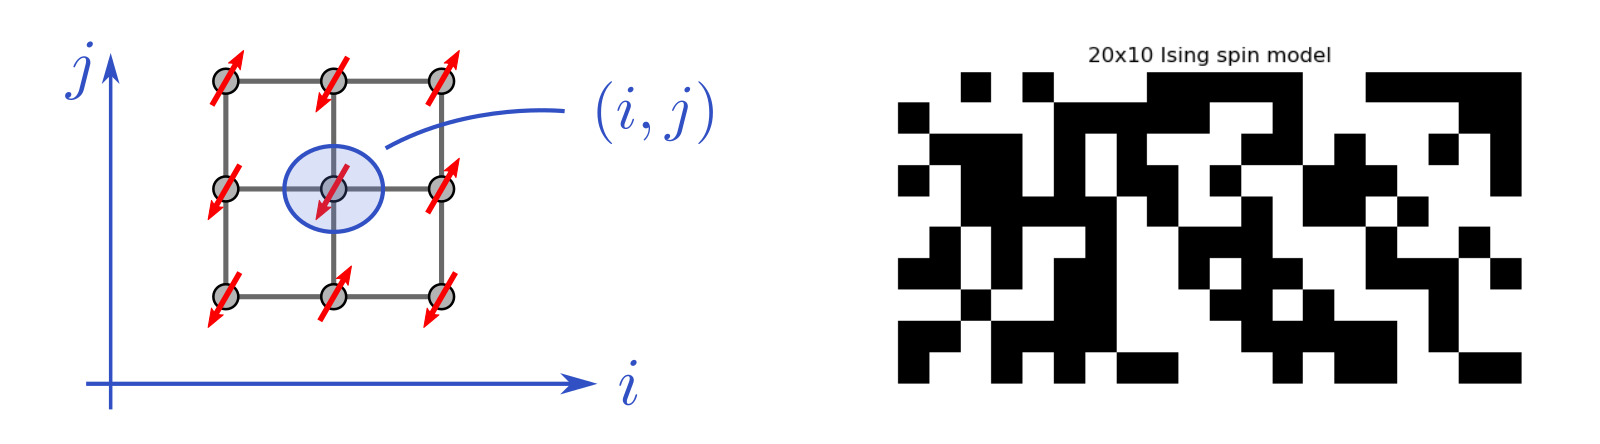

Wir möchten im folgenden eine numerische Simulation dieses Modell-Systems aufsetzen und anhand eines Monte Carlo-Verfahrens Observablen des Systems, insbesondere die Magnetisierung, berechnen. Diese numerischen Daten können wir dann mit den analytischen Ergebnissen dieses Übungsblattes vergleichen. 

Zugleich bauen wir uns damit auch eine Code-Basis für das folgende Übungsblatt, auf welchem wir den "Ising Ferromagneten" untersuchen werden.

# Metropolis Monte Carlo

Für die numerische Messung der Observablen haben Sie in der Computerphysik die Methode der Monte Carlo Integration sowie den dafür benötigten Metropolis Algorithmus kennengelernt. Wir stellen Ihnen hier eine mögliche Implementierung dieses Verfahrens als fast fertigen Code zur Verfügung (tatsächlich ist dies eine abgespeckte Version des Codes für den Ising Ferromagneten aus dem Sommersemester). 

Der Algorithmus läuft nach folgendem grundsätzlichen Schema ab:

1. Zuerst werden Funktionen implementiert, die Ising Spins einzeln oder als Vielteilchen-Konfiguration erzeugen und diese plotten. Damit wird im Programm die Möglichkeit geschaffen, Konfigurationen von Spins zu erzeugen und zu untersuchen.
2. Für die bestehenden Konfigurationen wird eine Energie nach oben stehendem Hamiltonian definiert. 
3. Mit Hilfe der Energie lässt sich ein einzelner Metropolis-Update als Funktion definieren. Speziell werden hier die Übergangswahrscheinlichkeiten so implementiert, dass Konfigurationen gemäss der Boltzmann-Gewichte erzeugt werden wenn wir eine längere Markov-Kette erzeugen (siehe Computer-Physik).
4. Als letzter Schritt folgt die Messung thermodynamischer Observablen entlang dieser Markov-Kette (also nach jedem Metropolis-Update).

Führen Sie für die Implementation der Funktionen nachfolgende Zellen aus.


### 1. Ising spins erzeugen und darstellen

In [ ]:
function get_Ising_spin()
    # Pruefe ob Zufallszahl zwischen 0 und 1 groesser als 0.5
    if rand() > 0.5
        return +1
    else
        return -1
    end
end

In [ ]:
function get_Ising_spins(Lx, Ly)
    # neues Array fuer die Ising Spins
    spins = zeros(Int64, Lx, Ly)
    # Alle Spins im Array auf zufaeelige Spins setzen
    for i in 1:Lx
    for j in 1:Ly
        spins[i,j] = get_Ising_spin()
    end
    end
    # Spins zurueckgeben
    return spins
end

In [ ]:
# Importieren von PyPlot
using PyPlot
pygui(false)

function plot_Ising_spins(spins)
    # neue Figur anlegen
    figure()    
    # Die Spins plotten mittels imshow (in Schwarz-Weiss)
    imshow(spins', cmap="gray", origin="lower", interpolation="None", vmin=-1, vmax=1)
    # keine Axenbeschriftung
    axis("off")
end

In [ ]:
# Beispiel: 20x10 zufällige Ising Spins erzeugen und plotten
plot_Ising_spins(get_Ising_spins(20, 10));

### 2. Energie einer Konfiguration

Beachte, dass wir die Gesamtenergie aller Spins in eine Summe der Energien einzelner Spins umschreiben können

\begin{align*}
    \mathcal{H} &= \sum_{\alpha} -h \sigma_\alpha  =  \sum_{\alpha} \mathcal{H}_\alpha
\end{align*}


wobei $\mathcal{H}_\alpha = -h \sigma_\alpha$ die Energie eines einzelnen Spins beschreibt.

In [ ]:
function get_energy_of_spin(spin_array, h, i,j)
    return -h*spin_array[i,j]
end

In [ ]:
function get_energy(spin_array, h)
    energy = 0.0
    for i in 1:size(spin_array)[1]
    for j in 1:size(spin_array)[2]
        energy += get_energy_of_spin(spin_array, h, i,j)
    end
    end
    return energy
end

### 3. Metropolis Algorithmus

Hier benötigen wir zwei wesentliche Elemente:
1. das **Update**, um von einer Konfiguration der Markov-Kette in eine Nächste überzugehen
2. die **Energiedifferenz** durch dieses Update

Wir wählen als Update das **Flippen eines einzelnen Spins $\sigma_\alpha$**. Damit ist die Energiedifferenz

\begin{align*}
    \Delta E &= \sum_{\alpha} -h \sigma'_\alpha - \sum_{\alpha} -h \sigma_\alpha  \\
        &= 2 h \sigma_\alpha 
\end{align*}


*Hinweis (1): Das Berechnen der **Gesamtenergie** ist für die Berechnung der Energiedifferenz nicht nötig!* 

*Hinweis (2): Damit sich einzelne untersuchte Konfigurationen stärker voneinander unterscheiden können, werden wir in der Praxis immer $N$ Updates für ein System aus $N$ Spins zu einem sogenannten **Sweep** zusammenfassen und die Messung der Observablen nur nach ganzen Sweeps durchführen.*

In [ ]:
function update_SSF!(spin_array, h, T)
    # Update vorschlagen
    i = rand(1:size(spin_array)[1])
    j = rand(1:size(spin_array)[2])
    # dE ausrechnen
    dE = 2*h*spin_array[i,j]
    # Akzeptieren Ja / Nein
    if rand() < exp(-dE / T)
        # JA
        spin_array[i,j] *= -1
    else
        # NEIN
    end
end

In [ ]:
function sweep_SSF!(spin_array, h, T)
    # Anzahl spins an Update vorschlagen
    for u in 1:size(spin_array)[1]*size(spin_array)[2]
        update_SSF!(spin_array, h, T)
    end
end

### 4. Berechnung von Observablen

Um Observablen mit Hilfe des Metropolis Algorithmus zu berechnen, müssen wir mit dem Programm eine Markov-Kette erzeugen und die Messungen der Observablen in Konfigurationen dieser Kette mitteln. Wir wissen bereits, dass für den Limes langer Markov-Ketten der Fehler bei dieser Mittelung klein wird (Gesetz der großen Zahl).

Eine zusätzliche Komplikation kommt von der sogenannten Thermalisierung. Wenn wir die Markov-Kette initialisieren, wählen wir eine zufällige Verteilung von Spins als erste Konfiguration. Diese ist aber nicht zwingend Teil der konvergierenden Markov-Kette, sondern vielmher Bestandteil einer Thermalisierungsphase. Daher werden die ersten Konfigurationen der Markov-Kette vernachlässigt und gehen nicht in die Berechnung der Mittelwerte ein.

Nachfolgendes Beispiel soll verdeutlichen, wie die Magnetisierung $M = \sum_\alpha \sigma_\alpha$ für gegebene Temperatur $T$ und Magnetfeldstärke $h$ berechnet wird.

In [ ]:
# Magnetisierung definieren
function get_magnetization(spin_array)
    return sum(spin_array)
end

In [ ]:
# Parameter wählen
h = -2
T = 2

# eine erste Konfiguration der Größe 20x10 erzeugen
spins = get_Ising_spins(20, 10)

# 100 sweeps durchführen, welche die Markov-Kette generieren
# es werden noch keine Mittelwerte berechnet
for i in 1:100
    sweep_SSF!(spins, h, T)
end

# 100 sweeps durchführen, welche die Markov-Kette weiter generieren
# Observable wird in jedem Sweep gemessen
m_vals = zeros(100)
for i in 1:length(m_vals)
    sweep_SSF!(spins, h, T)
    m_vals[i] = get_magnetization(spins) / length(spins)
end
# Mittelwert der Observable wird ermittelt
m = sum(m_vals) / length(m_vals)


println("Mittlere Magnetisierung pro Spin: ", m)

# Aufgabenstellung: Magnetisierung vs. Magnetfeld für verschiedene Temperaturen

Berechnen Sie die Magnetisierung pro Spin in Abhängigkeit des angelegten Magnetfeldes für verschiedene Werte der Temperatur. Vergleichen Sie mit den analytischen Kurvenverläufen. Benutzen Sie dafür Magnetfelder von $h = -5$ bis $h =5$, sowie Temperaturen $T=0.1, 1.0, 5.0, 10.0$.